### Importing Libraries

In [ ]:
pip install plotly

In [ ]:
pip install squarify

In [ ]:
!pip install pmdarima

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from fbprophet import Prophet

%matplotlib inline

### Importing Stokprices Dataset

In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
Stock = pd.read_csv('prices.csv',parse_dates=['date'], date_parser=dateparse)
pd.set_option('display.max_columns', None)
Stock.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


### Dataset Profiling 

In [3]:
print("Dataset dimension :", Stock.ndim)
print("Dataset shape :", Stock.shape)
print("Dataset size :", Stock.size)

Dataset dimension : 2
Dataset shape : (851264, 7)
Dataset size : 5958848


In [4]:
Stock_types = Stock.dtypes.reset_index()
Stock_types.columns = ['Features','Data Types']
Stock_types

,Features,Data Types
0,date,datetime64[ns]
1,symbol,object
2,open,float64
3,close,float64
4,low,float64
5,high,float64
6,volume,float64


### Dataset Inspection

### Dataset Missing and Blank Value Check

In [5]:
miss_data = Stock.isnull().sum().reset_index()
miss_data.columns = ['Features','Missing Values']
blank_data = Stock.apply(lambda x: x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(miss_data,blank_data, on=['Features'])
merged_data['Filling Factor'] = (Stock.shape[0]-miss_data['Missing Values'] + Stock.shape[0]-blank_data['Blank Values'])/Stock.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
0,date,0,0,100.0
1,symbol,0,0,100.0
2,open,0,0,100.0
3,close,0,0,100.0
4,low,0,0,100.0
5,high,0,0,100.0
6,volume,0,0,100.0


### Checking Symbol Unique Values

In [6]:
sy_count = Stock['symbol'].value_counts().reset_index()
sy_count.columns = ['symbol','Total Counts']
sy_count.sort_values(by='Total Counts',ascending=False)
sy_count.head(10)

,symbol,Total Counts
0,KSU,1762
1,NOC,1762
2,ORCL,1762
3,OMC,1762
4,OKE,1762
5,O,1762
6,NWL,1762
7,NVDA,1762
8,NUE,1762
9,NTRS,1762


### Choosing and Sampling 3 Companies Stockprices For Analysis

Oracle Corporation and OneOK, each of these companies are labeled as follows in dataset:
 - ORCL
 - OKE

### Creating New Dataframe based on the Companies Chosen

### Oracle Corporation

In [7]:
ORCL = Stock.loc[Stock['symbol'] == 'ORCL']
ORCL

,date,symbol,open,close,low,high,volume
571,2010-01-04,ORCL,24.660000,24.850000,24.660000,25.190001,26795000.0
1039,2010-01-05,ORCL,24.719999,24.820000,24.350000,24.850000,28669900.0
1507,2010-01-06,ORCL,24.770000,24.459999,24.379999,24.920000,24560700.0
1975,2010-01-07,ORCL,24.459999,24.379999,24.080000,24.610001,30469700.0
2443,2010-01-08,ORCL,24.280001,24.680000,24.250000,24.750000,23542400.0
...,...,...,...,...,...,...,...
849107,2016-12-23,ORCL,38.790001,38.779999,38.630001,39.020000,8143600.0
849607,2016-12-27,ORCL,38.770000,38.820000,38.759998,39.040001,5073700.0
850107,2016-12-28,ORCL,38.869999,38.680000,38.630001,38.919998,8264100.0
850607,2016-12-29,ORCL,38.610001,38.689999,38.610001,38.840000,5711800.0


### OneOK

In [8]:
OKE = Stock.loc[Stock['symbol'] == 'OKE']
OKE

,date,symbol,open,close,low,high,volume
569,2010-01-04,OKE,44.880002,45.579999,44.880002,45.709999,1759600.0
1037,2010-01-05,OKE,45.500002,45.180000,44.589999,45.749998,3324900.0
1505,2010-01-06,OKE,45.270001,45.440000,45.000002,45.530001,1769400.0
1973,2010-01-07,OKE,45.510002,45.140001,44.839999,45.510002,1609800.0
2441,2010-01-08,OKE,45.109998,45.400001,44.770001,45.449999,1061300.0
...,...,...,...,...,...,...,...
849105,2016-12-23,OKE,58.040001,58.689999,57.790001,58.810001,886000.0
849605,2016-12-27,OKE,58.980000,59.029999,58.490002,59.470001,1232400.0
850105,2016-12-28,OKE,59.020000,57.669998,57.639999,59.230000,1275500.0
850605,2016-12-29,OKE,57.660000,57.980000,57.580002,58.119999,995600.0


### Dataset Data Range Date

### Oracle 

In [9]:
print("Oracle Minimum date value : {}".format(ORCL['date'].min()))
print("Oracle Maximum date value : {}".format(ORCL['date'].max()))

Oracle Minimum date value : 2010-01-04 00:00:00
Oracle Maximum date value : 2016-12-30 00:00:00


### ONEOK

In [10]:
print("ONEOK Minimum date value : {}".format(OKE['date'].min()))
print("ONEOK Maximum date value : {}".format(OKE['date'].max()))

ONEOK Minimum date value : 2010-01-04 00:00:00
ONEOK Maximum date value : 2016-12-30 00:00:00


### Exploratory Data Analysis

### Oracle Stock Changes Overtime

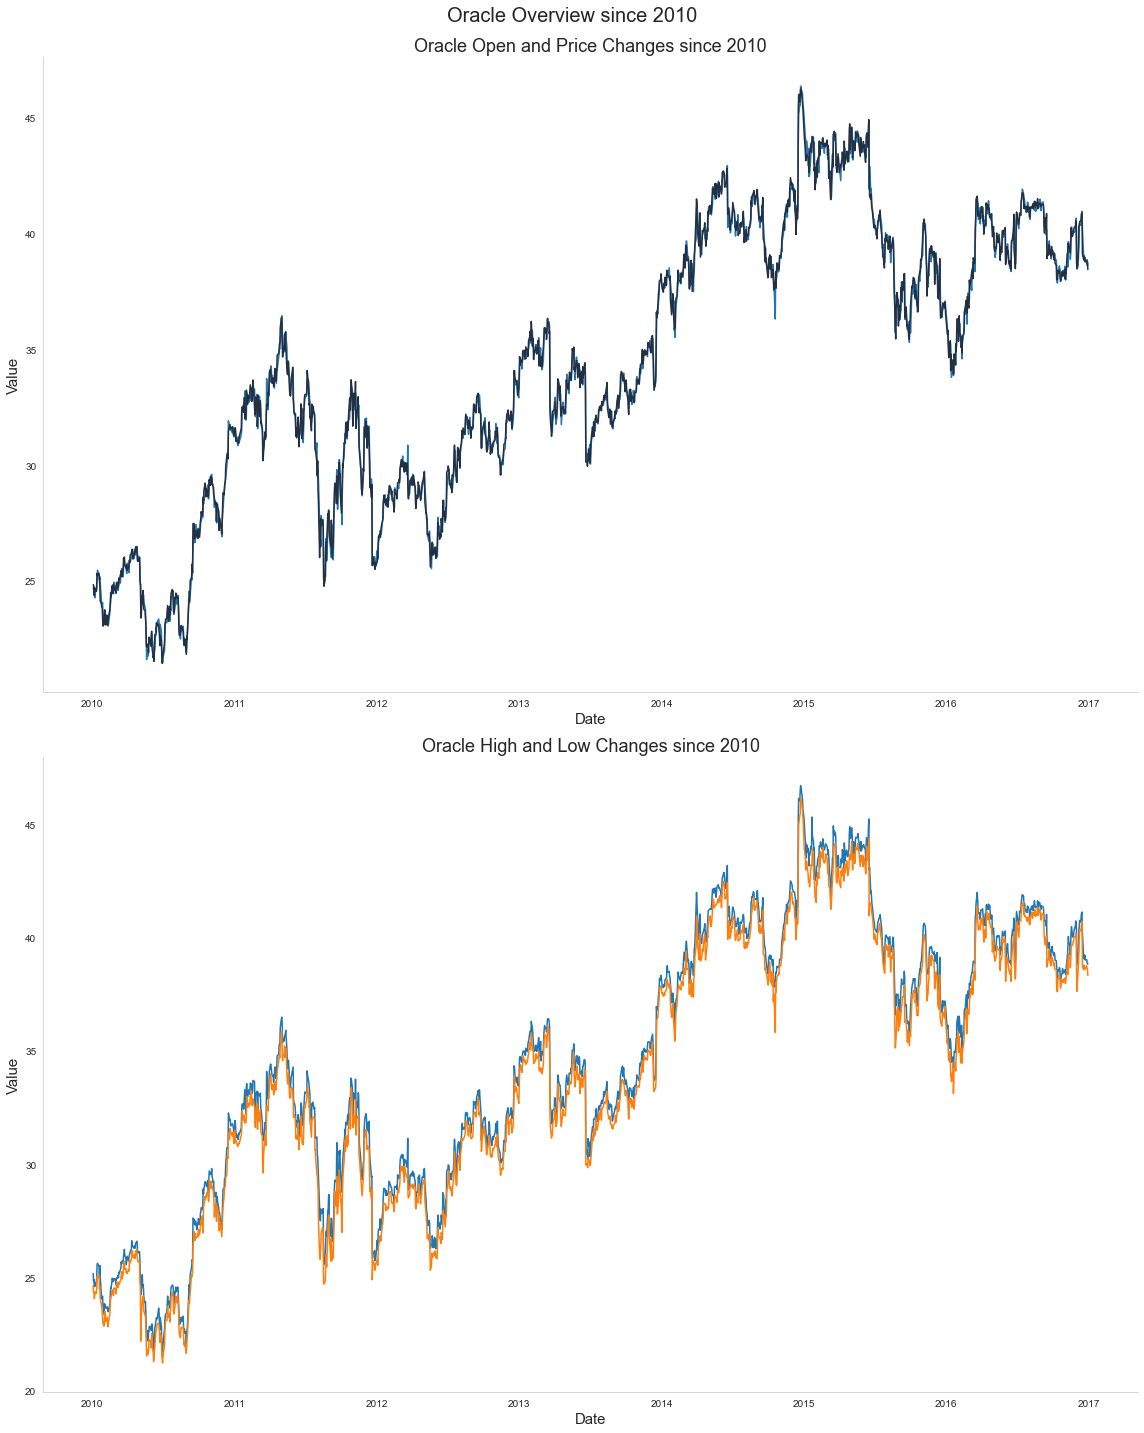

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Oracle Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
colors1 = ['#FF9A00','#242F41']

ax1=sns.lineplot(data=ORCL, x='date',y='open',ax=ax1)
ax1=sns.lineplot(data=ORCL, x='date',y='close',ax=ax1, color=colors1[1])
ax1.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax1.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Oracle Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax2=sns.lineplot(data=ORCL, x='date',y='high',ax=ax2)
ax2=sns.lineplot(data=ORCL, x='date',y='low',ax=ax2)
ax2.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax2.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Oracle High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'Oracle Volume Changes since 2010')

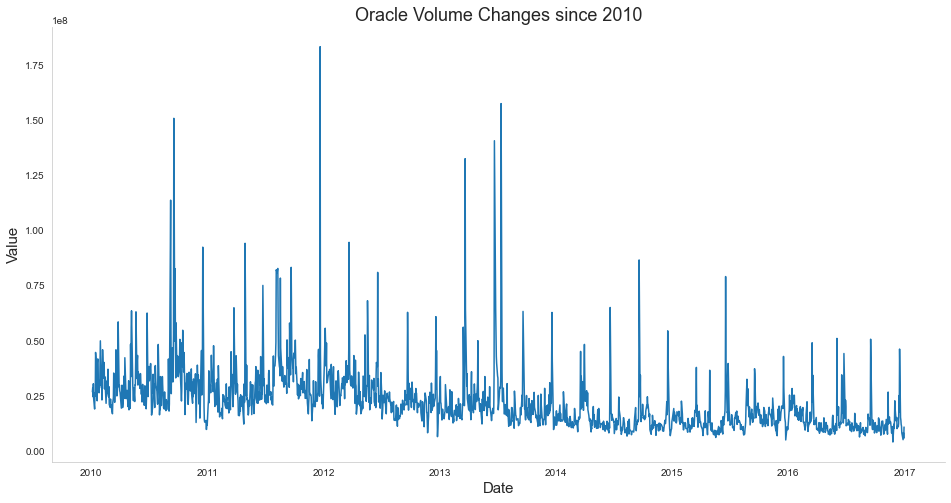

In [12]:
fig3=plt.figure(figsize=(16,8))
ax3=sns.lineplot(data=ORCL, x='date',y='volume')
ax3.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax3.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Oracle Volume Changes since 2010',fontsize=18, fontweight='normal')

### Oracle Numerical Feature Plot

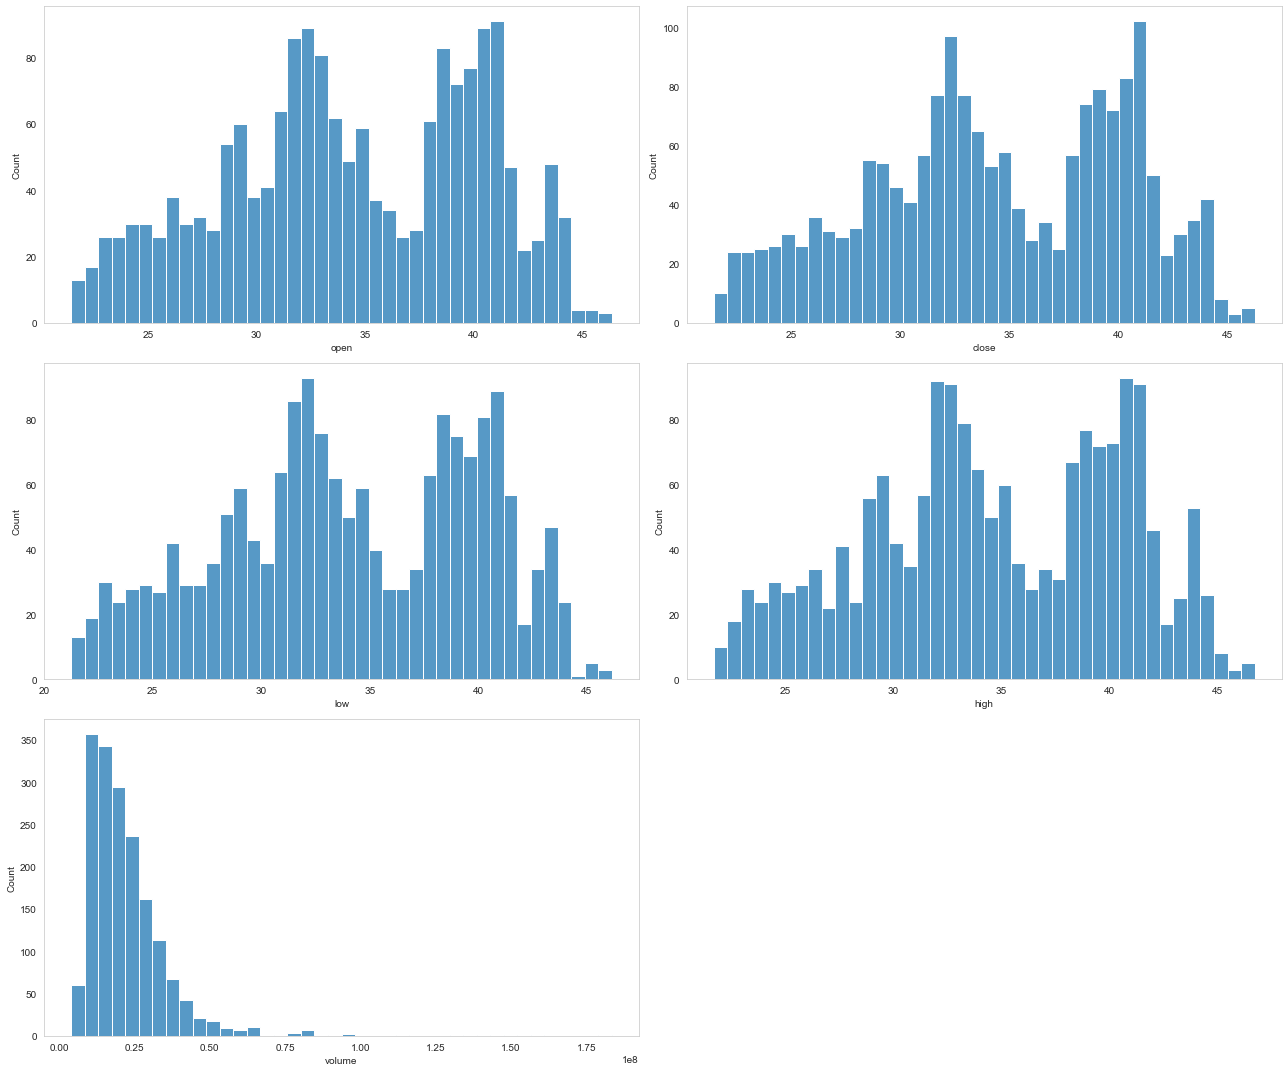

In [13]:
ORCL_num = ORCL[['open','close','low','high','volume']]

plt.figure(figsize=(18, 15))
for i in range(0, len(list(ORCL_num))):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=ORCL[list(ORCL_num)[i]],bins = 40)
    plt.tight_layout()

### Oracle Outliers Checking

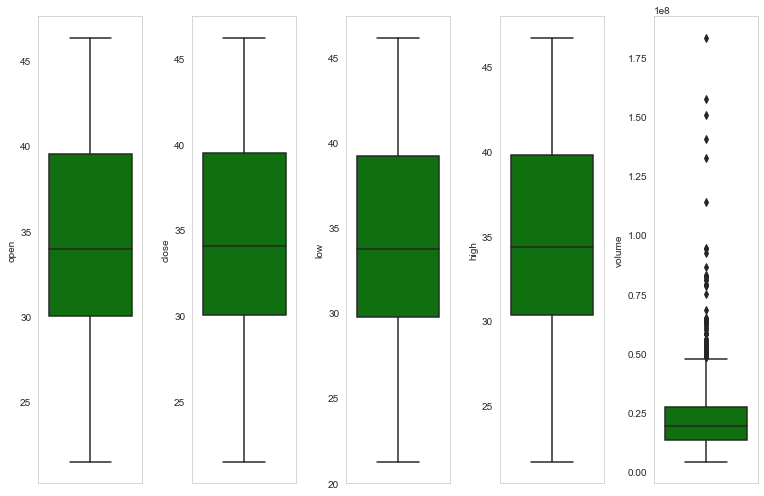

In [14]:
plt.figure(figsize=(15, 7))
for i in range(0, len(list(ORCL_num))):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=ORCL[list(ORCL_num)[i]],color='green',orient='v')
    plt.tight_layout()

### ONEOKE Stock Changes Overtime

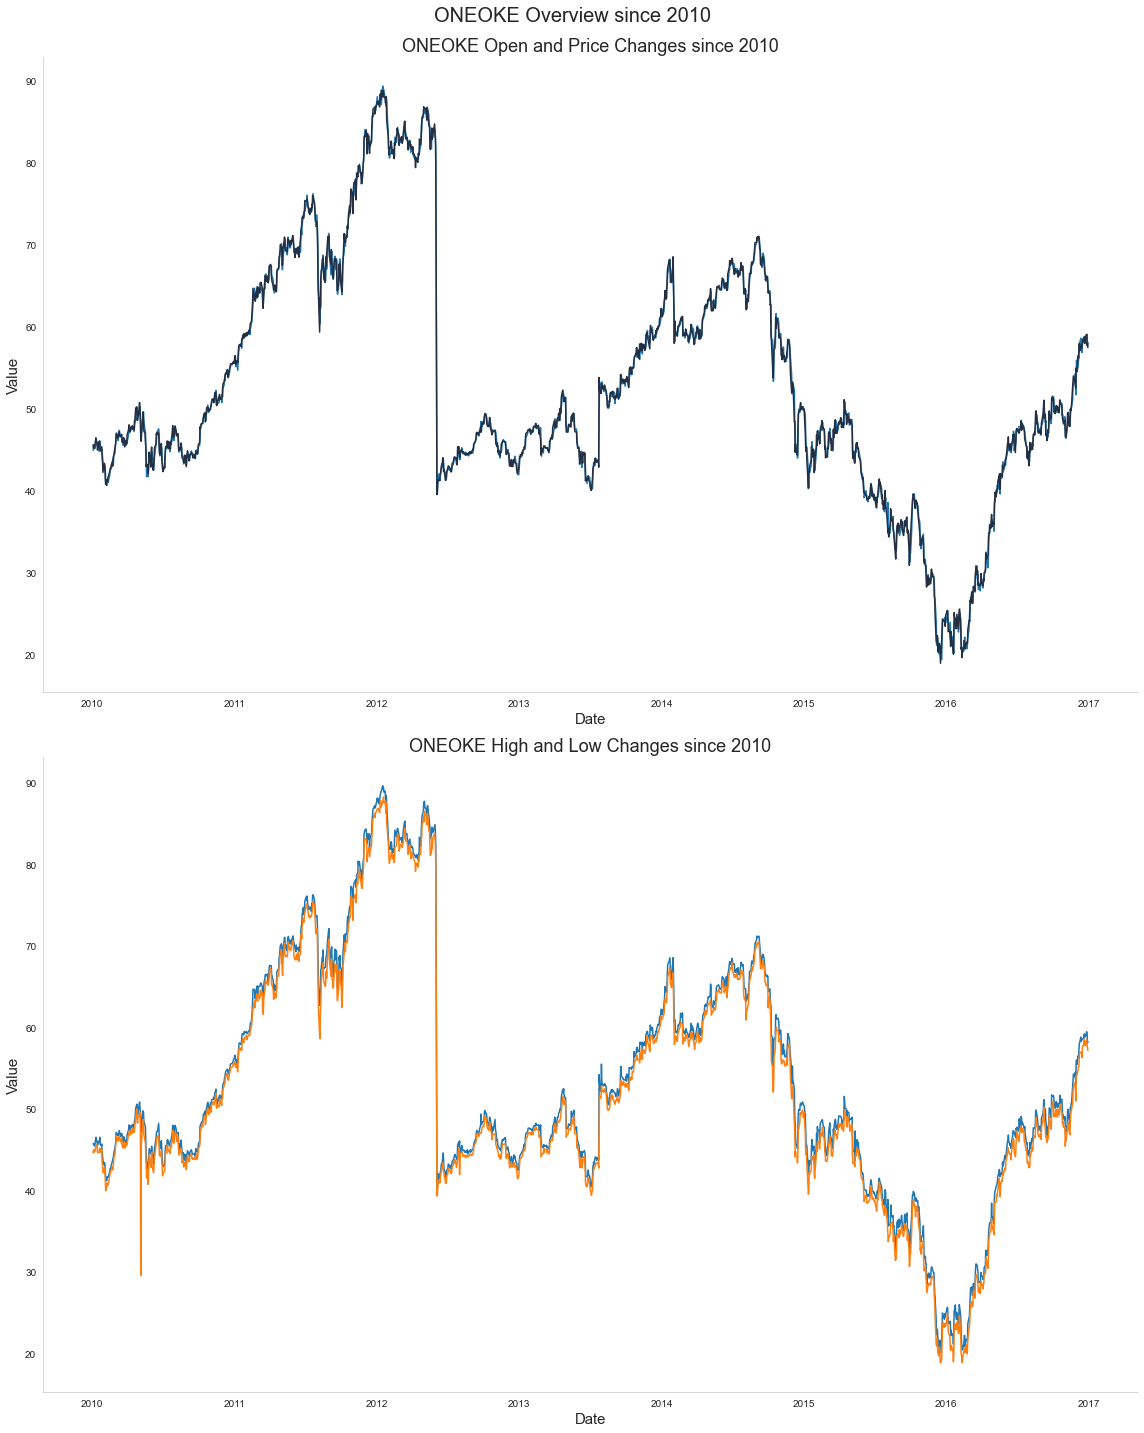

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
colors2 = ['#F80000','#242F41']

fig, (ax4, ax5) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("ONEOKE Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
ax4=sns.lineplot(data=OKE, x='date',y='open',ax=ax4)
ax4=sns.lineplot(data=OKE, x='date',y='close',ax=ax4, color=colors2[1])
ax4.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax4.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title('ONEOKE Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax5=sns.lineplot(data=OKE, x='date',y='high',ax=ax5)
ax5=sns.lineplot(data=OKE, x='date',y='low',ax=ax5)
ax5.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax5.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title('ONEOKE High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'ONEOKE Volume Changes since 2010')

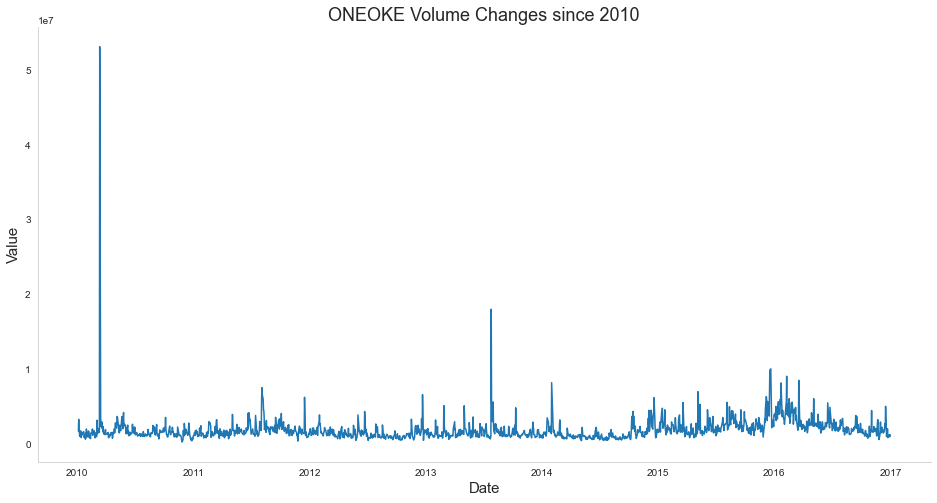

In [16]:
fig6=plt.figure(figsize=(16,8))
ax6=sns.lineplot(data=OKE, x='date',y='volume')
ax6.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax6.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_title('ONEOKE Volume Changes since 2010',fontsize=18, fontweight='normal')

### OneOK Numerical Features Plotting

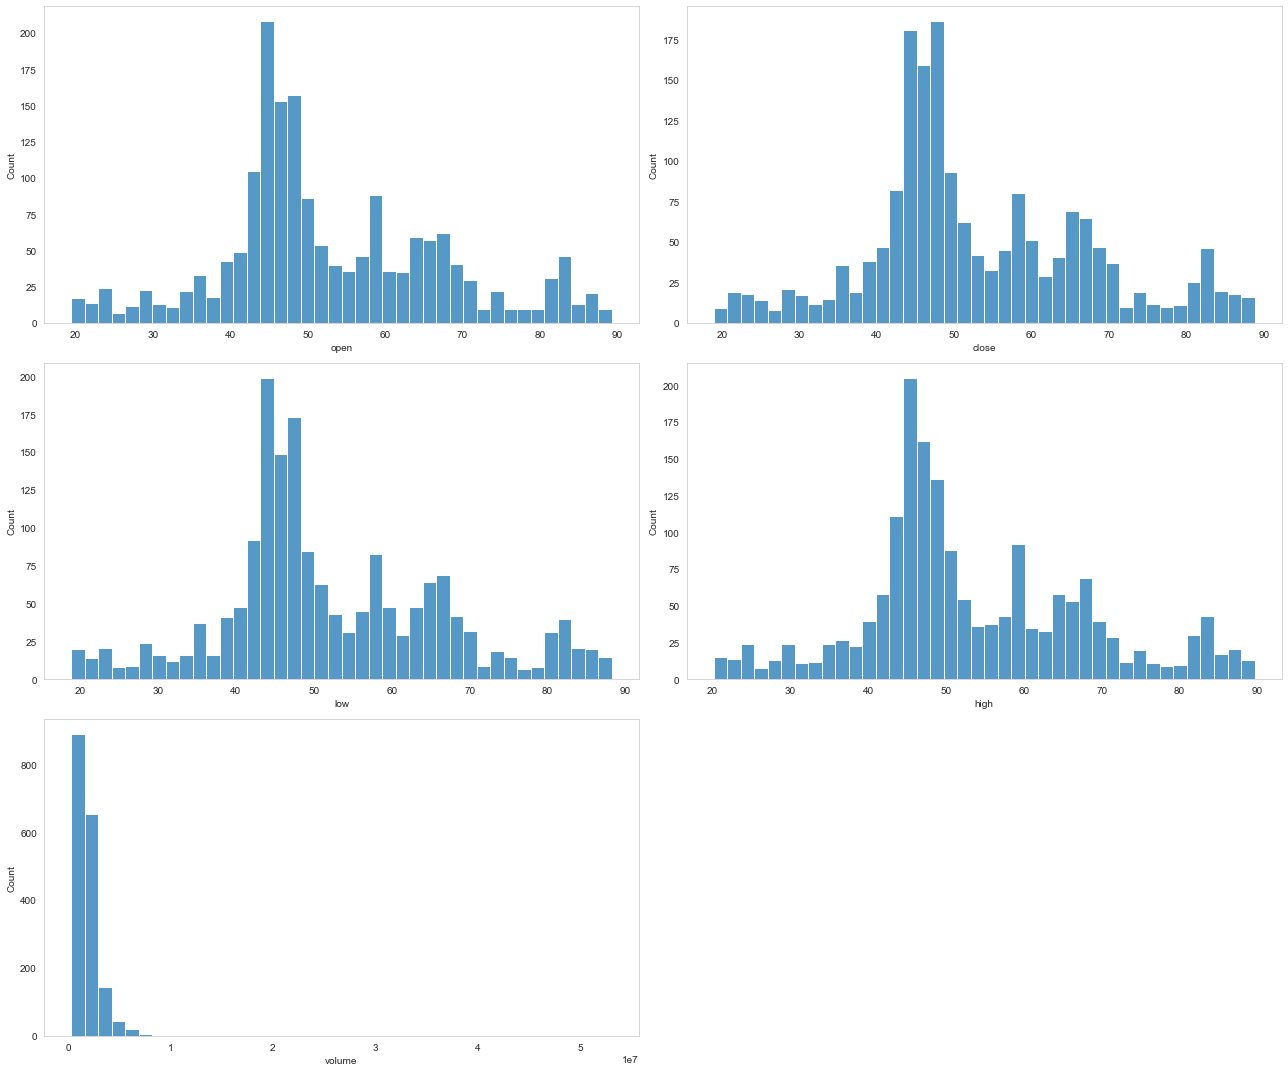

In [17]:
OKE_num = OKE[['open','close','low','high','volume']]

plt.figure(figsize=(18, 15))
for i in range(0, len(list(OKE_num))):
    plt.subplot(3, 2, i+1)
    sns.histplot(x=OKE[list(OKE_num)[i]],bins = 40)
    plt.tight_layout()

### OneOK Outliers Checking

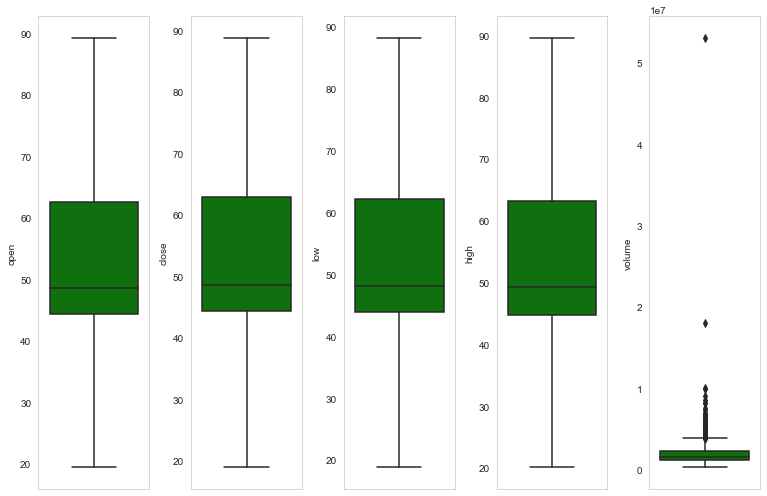

In [18]:
plt.figure(figsize=(15, 7))
for i in range(0, len(list(OKE_num))):
    plt.subplot(1, 7, i+1)
    sns.boxplot(y=OKE[list(OKE_num)[i]],color='green',orient='v')
    plt.tight_layout()

### Time Series Stasionary Checking

### Oracle

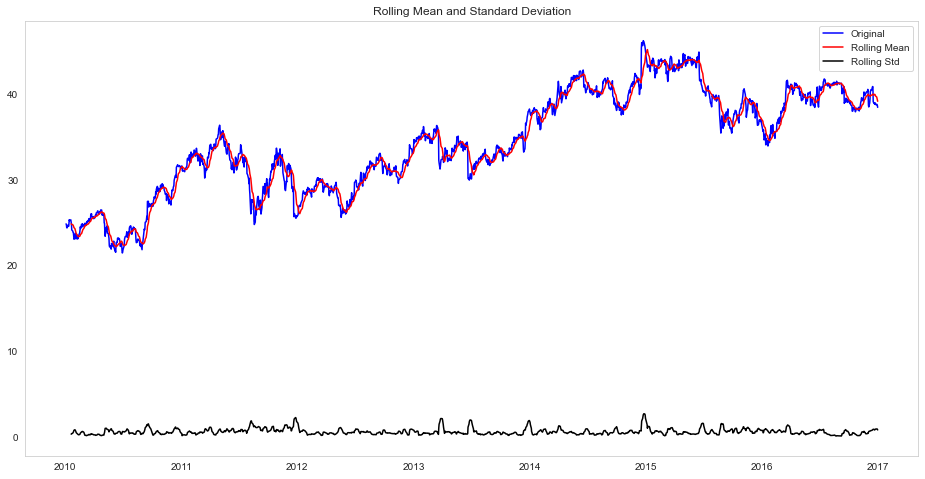

Results of dickey fuller test
Test Statistics                  -2.099797
p-value                           0.244596
No. of lags used                  0.000000
Number of observations used    1761.000000
critical value (1%)              -3.434069
critical value (5%)              -2.863183
critical value (10%)             -2.567645
dtype: float64


In [19]:
# Setting Date as Index
ORCL_date_index = ORCL.set_index('date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ORCL_date_index['close'])

### ONEOKE

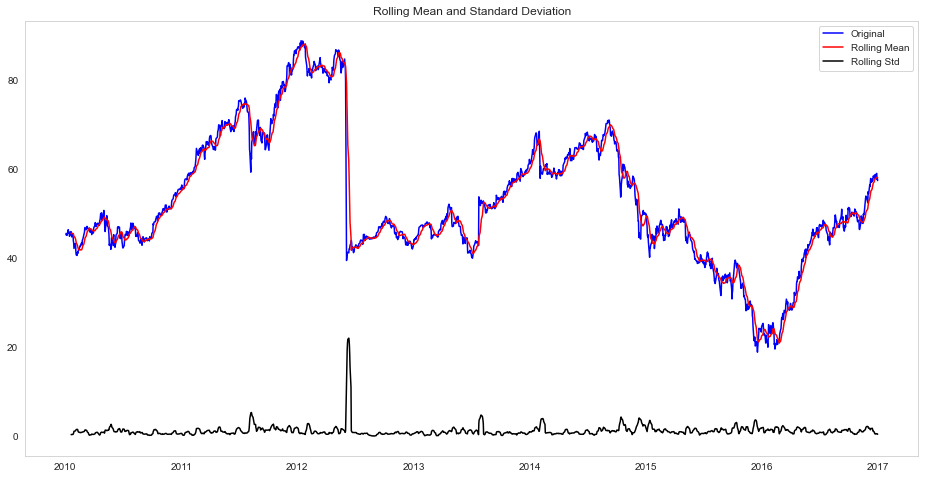

Results of dickey fuller test
Test Statistics                  -2.047261
p-value                           0.266243
No. of lags used                  1.000000
Number of observations used    1760.000000
critical value (1%)              -3.434071
critical value (5%)              -2.863184
critical value (10%)             -2.567645
dtype: float64


In [20]:
# Setting Date as Index
OKE_date_index = OKE.set_index('date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(OKE_date_index['close'])

### Time Series Decomposition

### Oracle

### Multiplicative

<Figure size 432x288 with 0 Axes>

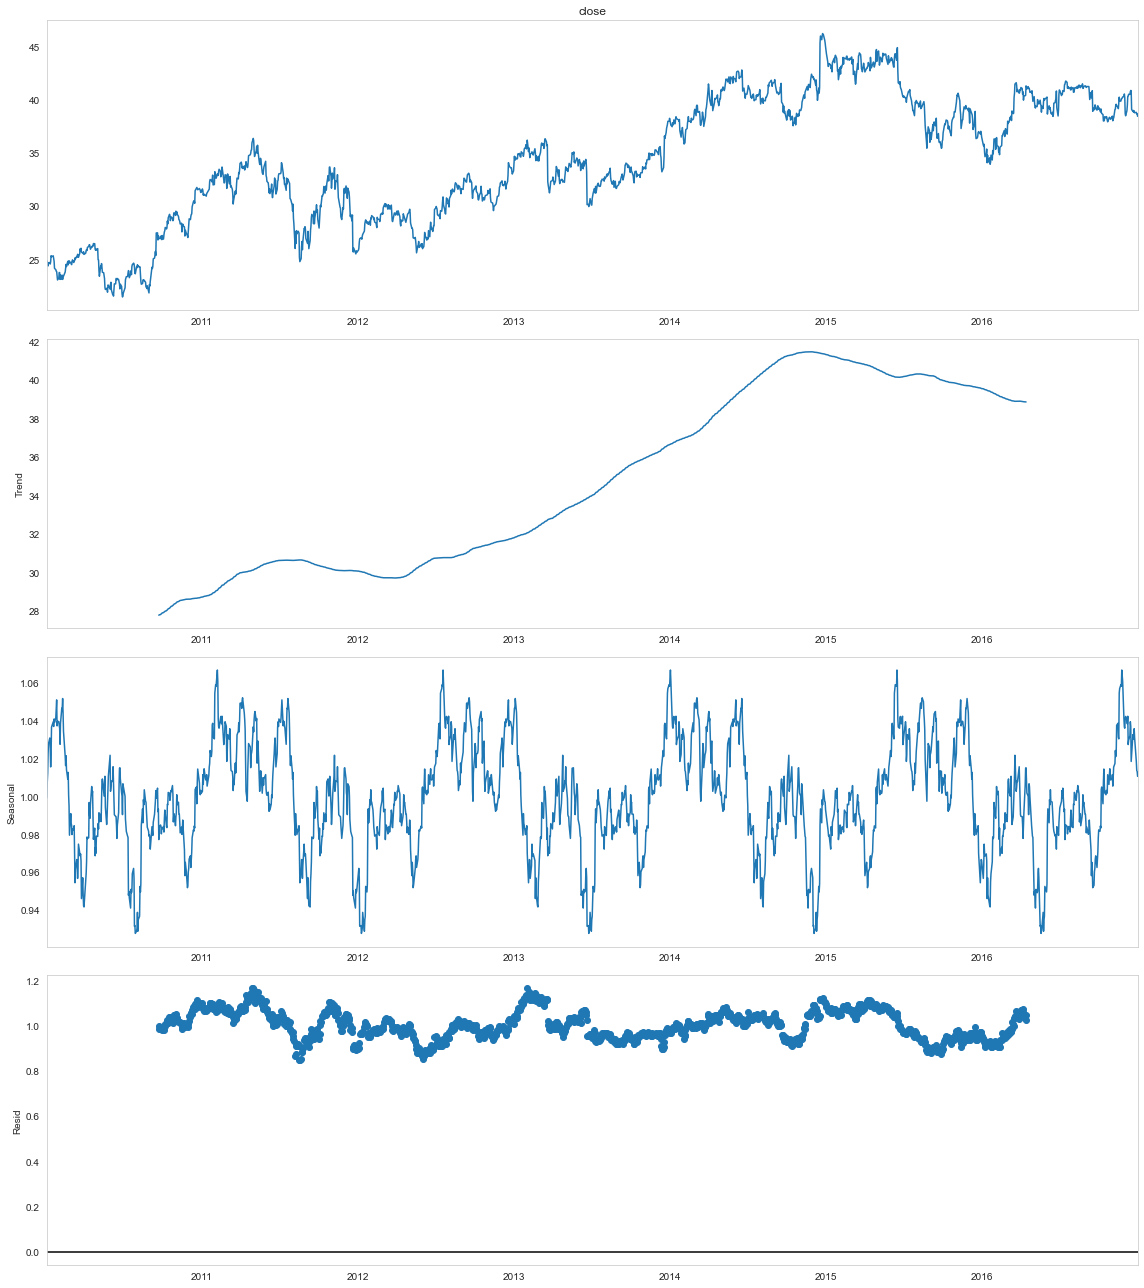

In [28]:
result1 = seasonal_decompose(ORCL_date_index['close'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result1.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

In [ ]:
result2 = seasonal_decompose(ORCL_date_index['close'], model='additive', period = 365)
fig = plt.figure()  
fig = result2.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### ONEOKE

### Multiplicative

<Figure size 432x288 with 0 Axes>

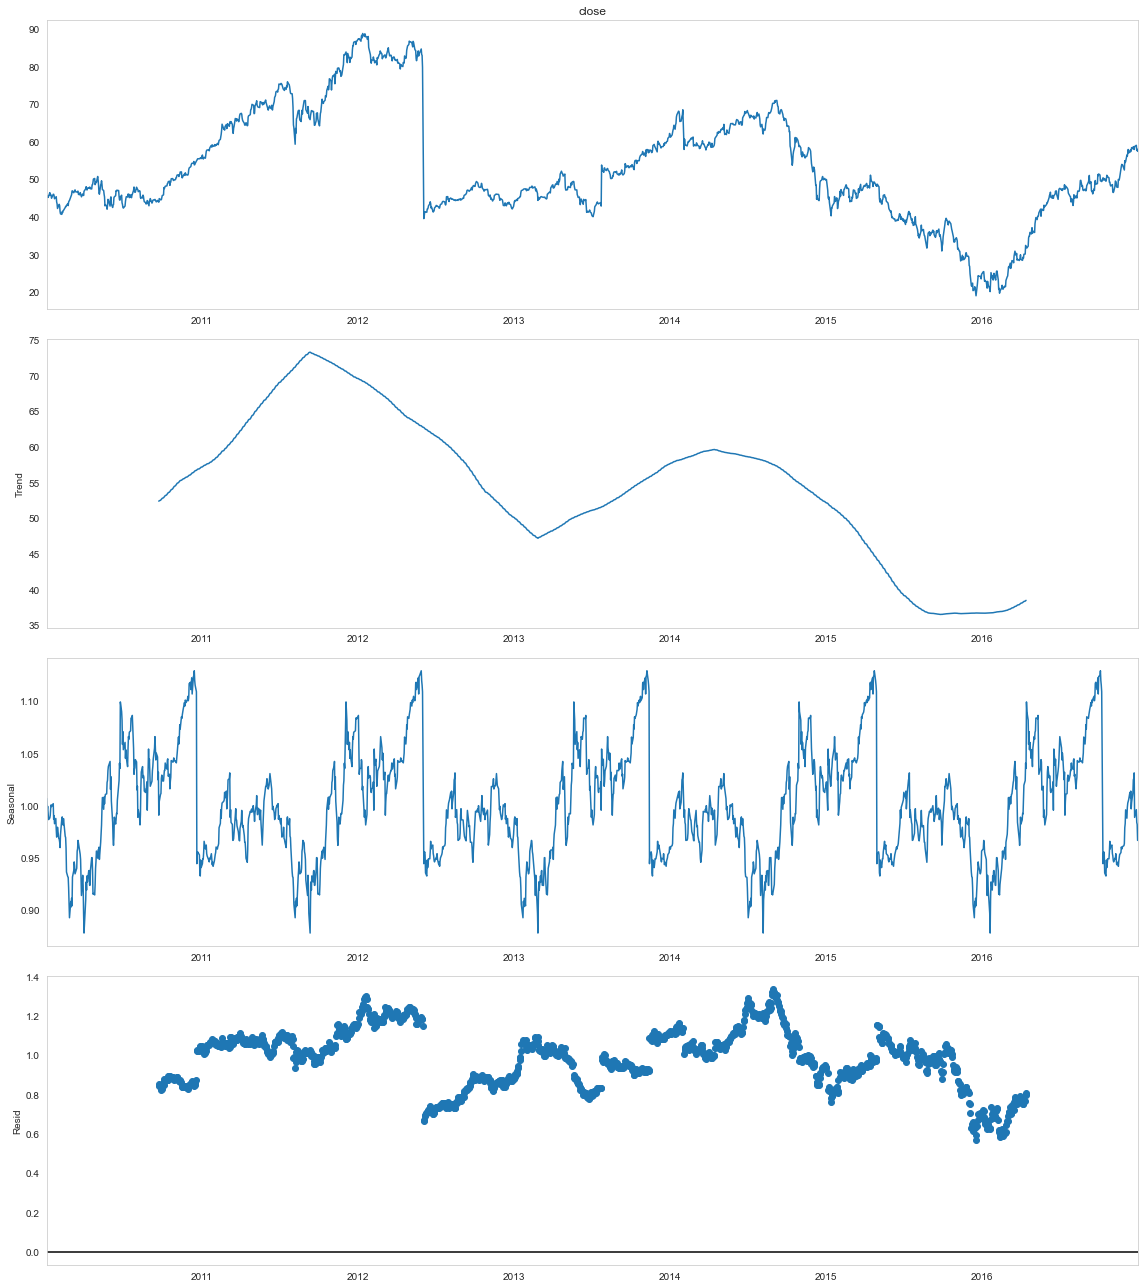

In [52]:
result3 = seasonal_decompose(OKE_date_index['close'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result3.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

In [ ]:
result4 = seasonal_decompose(OKE_date_index['close'], model='additive', period = 365)
fig = plt.figure()  
fig = result4.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Preparing Dataset For Forecasting / Predictive Model

### Oracle

No handles with labels found to put in legend.


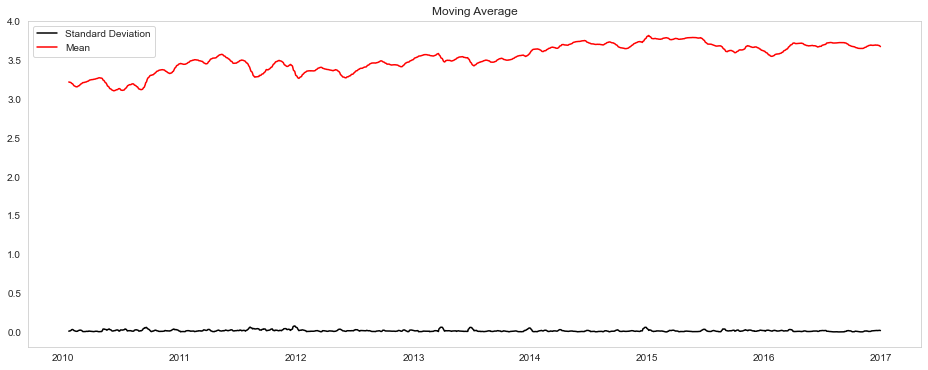

In [23]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
ORCL_log = np.log(ORCL_date_index['close'])
moving_avg = ORCL_log.rolling(12).mean()
std_dev = ORCL_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

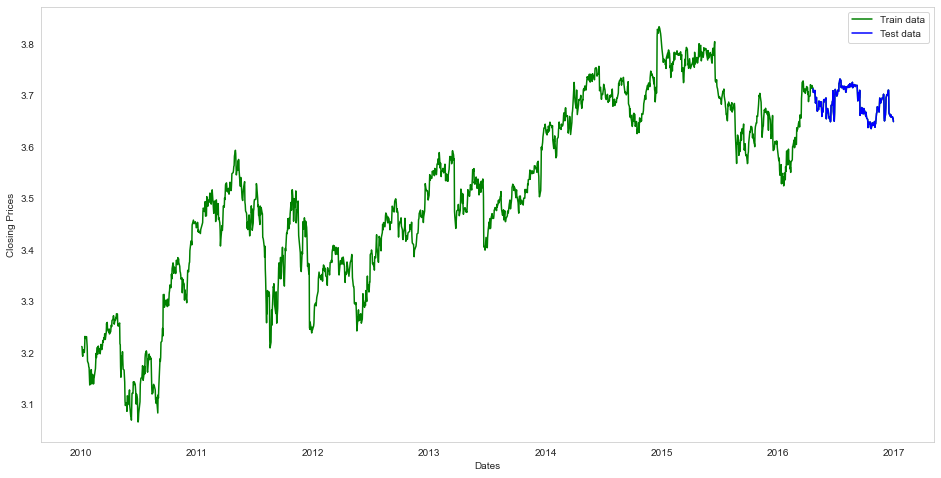

In [25]:
# Split data into Train and Training set
train_data1, test_data1 = ORCL_log[5:int(len(ORCL_log)*0.9)], ORCL_log[int(len(ORCL_log)*0.9):]
plt.figure(figsize=(16,8))
##plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(ORCL_log, 'green', label='Train data')
plt.plot(test_data1, 'blue', label='Test data')
plt.legend()

### ONEOKE

No handles with labels found to put in legend.


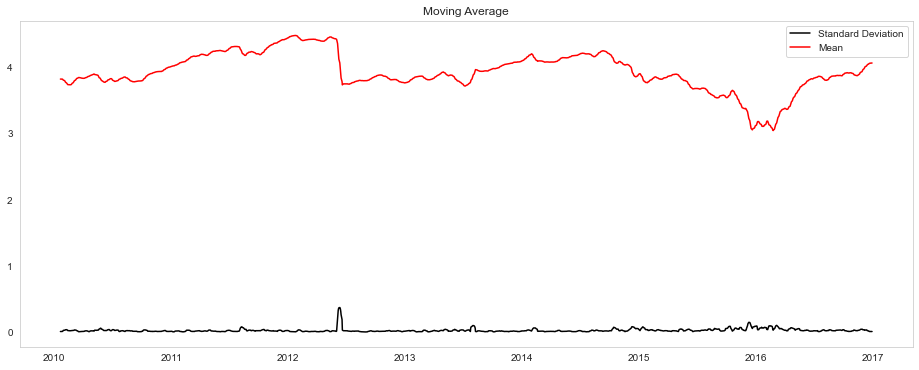

In [26]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
OKE_log = np.log(OKE_date_index['close'])
moving_avg2 = OKE_log.rolling(12).mean()
std_dev2 = OKE_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev2, color ="black", label = "Standard Deviation")
plt.plot(moving_avg2, color="red", label = "Mean")
plt.legend()
plt.show()

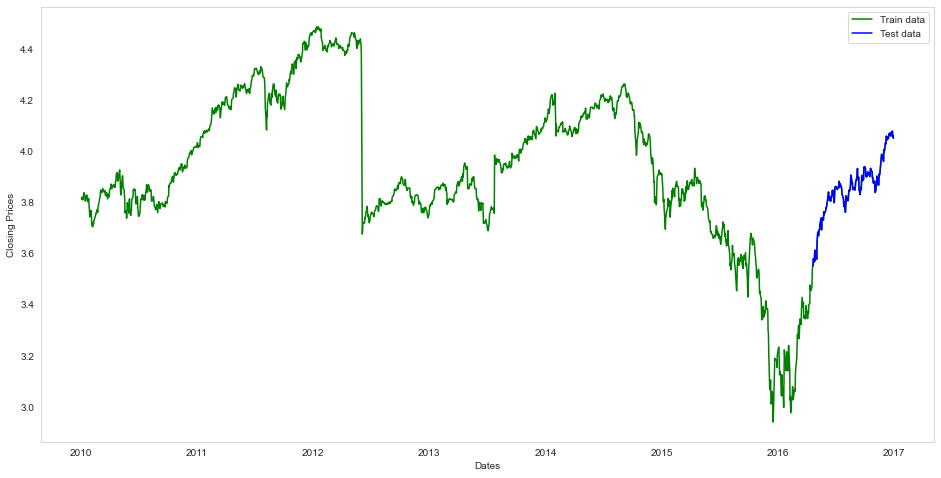

In [27]:
# Split data into Train and Training set
train_data2, test_data2 = OKE_log[5:int(len(OKE_log)*0.9)], OKE_log[int(len(OKE_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(OKE_log, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

### AUTO ARIMA Model 

### Oracle

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-5580.574, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-8998.414, Time=4.59 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-7051.127, Time=2.61 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-5575.522, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-8480.469, Time=0.45 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-9195.287, Time=8.20 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=10.52 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-5589.541, Time=2.10 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-9187.920, Time=9.61 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-9193.465, Time=9.72 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-7050.223, Time=10.43 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-9192.319, Time=13.22 sec
 ARIMA(1,0,0)(2,1,0)

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


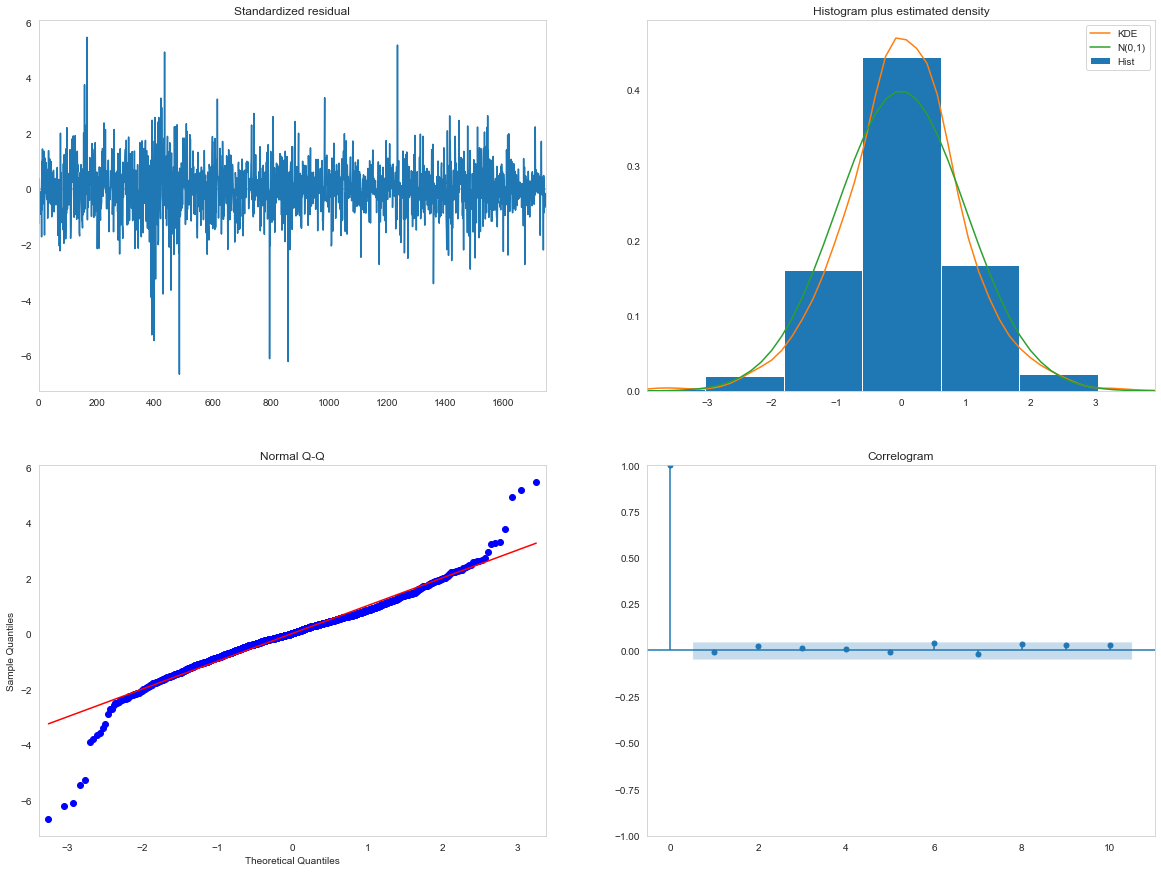

In [38]:
smodel1 = pm.auto_arima(ORCL_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel1.summary())
smodel1.plot_diagnostics(figsize=(20,15))
plt.show()

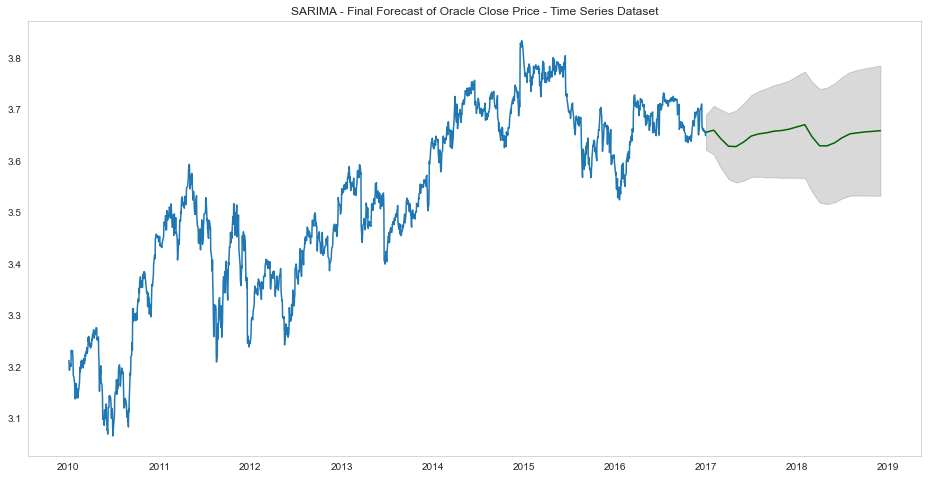

In [53]:
# Forecast
n_periods = 24
fitted, confint = smodel1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(ORCL_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,8))
plt.plot(ORCL_log)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Oracle Close Price - Time Series Dataset")
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

### ONEOKE

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=7.90 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-3349.229, Time=0.29 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-7029.216, Time=2.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-4943.650, Time=3.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-3350.668, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-6517.883, Time=0.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-7203.720, Time=6.58 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.30 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.43 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-3351.599, Time=1.82 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-7206.544, Time=9.89 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-7033.670, Time=4.15 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.02 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


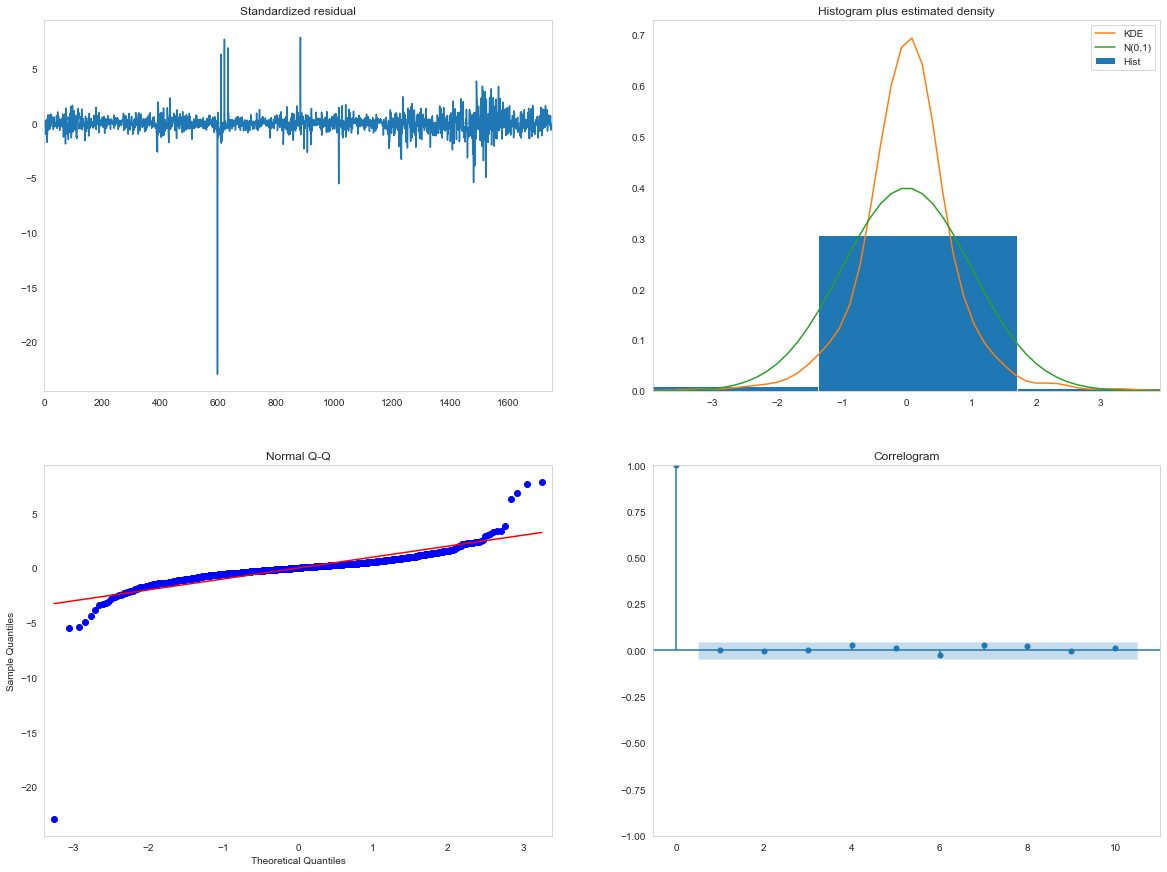

In [43]:
smodel2 = pm.auto_arima(OKE_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel2.summary())
smodel2.plot_diagnostics(figsize=(20,15))
plt.show()

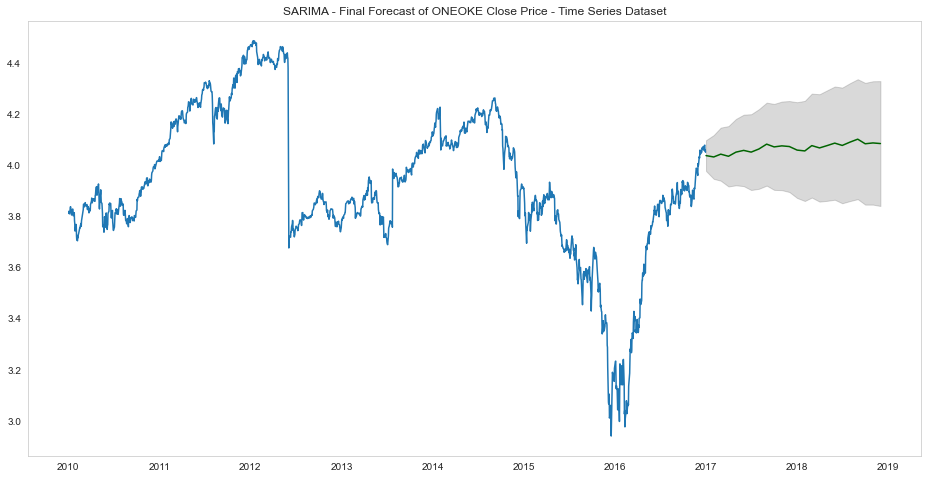

In [54]:
# Forecast
n_periods = 24
fitted2, confint = smodel2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc2 = pd.date_range(OKE_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series2 = pd.Series(fitted2, index=index_of_fc2)
lower_series2 = pd.Series(confint[:, 0], index=index_of_fc2)
upper_series2 = pd.Series(confint[:, 1], index=index_of_fc2)

# Plot
plt.figure(figsize=(16,8))
plt.plot(OKE_log)
plt.plot(fitted_series2, color='darkgreen')
plt.fill_between(lower_series2.index, 
                 lower_series2, 
                 upper_series2, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of ONEOKE Close Price - Time Series Dataset")
plt.show()

### Linear Regression Model

### Oracle Stock Train and Test Splitting

In [ ]:
# Determine Target Feature
X2 = ORCL[['volume','open']]
y2 = ORCL['close']

# Import Libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Splitting
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size=0.3, shuffle=False, random_state=50)

###  Oracle Dataset Train and Test Profiling

In [ ]:
# Train set Profiling
print("Train set dimension :", X2_train.ndim)
print("Train set shape :", X2_train.shape)
print("Train set size :", X2_train.size)

# Test set Profiling
print("Test set dimension :", X2_test.ndim)
print("Test set shape :", X2_test.shape)
print("Test set size :", X2_test.size)

### OneOK Stock Train and Test Splitting

In [ ]:
# Determine Target Feature
X3 = OKE[['volume','open']]
y3 = OKE['close']

# Import Libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Splitting
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3, test_size=0.3, shuffle=False, random_state=50)

###  OneOK Dataset Train and Test Profiling

In [ ]:
# Train set Profiling
print("Train set dimension :", X3_train.ndim)
print("Train set shape :", X3_train.shape)
print("Train set size :", X3_train.size)

# Test set Profiling
print("Test set dimension :", X3_test.ndim)
print("Test set shape :", X3_test.shape)
print("Test set size :", X3_test.size)

### Standarizing Set

In [ ]:
# Oracle Dataset Standarization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test =scaler.transform(X2_test)

# OneOK Dataset Standarization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X3_train = scaler.fit_transform(X3_train)
X3_test =scaler.transform(X3_test)

### Fittimg Model To Each Dataset

### Linear Regression Model (Oracle Dataset)

In [ ]:
# Specifiying Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config

# Fitting Model to Train and Test
model = LinearRegression()
model.fit(X2_train,y2_train)
set_config(display='diagram')
pred2 = model.predict(X2_test)
sc2 = np.round(model.score(X2_test, y2_test),2) * 100
r22 = np.round(r2_score(y2_test,pred2),2)
mse2 = np.round(mean_squared_error(y2_test,pred2),2)
mae2 = np.round(mean_squared_error(y2_test,pred2),2)

# Plot Model Result
fig5 = plt.figure(figsize=(20,8))
p2 = pd.Series(pred2, index = y2_test.index)
plt.plot(y2_test)
plt.plot(p2)
plt.legend(['y_test','predicted'])
plt.title("Compare test and predicted values", size=20, weight='bold')
plt.text(x=820000, y=36,s='Accuracy score : {} %'.format(sc2))
plt.text(x=820000, y=35.5,s='R2 Score : {}'.format(r22))
plt.text(x=820000, y=35,s='Mean Squared error : {}'.format(mse2))
plt.text(x=820000, y=34.5,s='Mean Absolute error : {}'.format(mae2))

### Linear Regression Model (OneOK Dataset)

In [ ]:
# Specifiying Libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config

# Fitting Model to Train and Test
model = LinearRegression()
model.fit(X3_train,y3_train)
set_config(display='diagram')
pred3 = model.predict(X3_test)
sc3 = np.round(model.score(X3_test, y3_test),2) * 100
r23 = np.round(r2_score(y3_test,pred3),2)
mse3 = np.round(mean_squared_error(y3_test,pred3),2)
mae3 = np.round(mean_squared_error(y3_test,pred3),2)

# Plot Model Result
fig6 = plt.figure(figsize=(20,8))
p3 = pd.Series(pred3, index = y3_test.index)
plt.plot(y3_test)
plt.plot(p3)
plt.legend(['y_test','predicted'])
plt.title("Compare test and predicted values", size=20, weight='bold')
plt.text(x=820000, y=28,s='Accuracy score : {} %'.format(sc3))
plt.text(x=820000, y=26,s='R2 Score : {}'.format(r23))
plt.text(x=820000, y=24,s='Mean Squared error : {}'.format(mse3))
plt.text(x=820000, y=22,s='Mean Absolute error : {}'.format(mae3))

### FBProphet Model

### Selecting and Renaming Dataset To Fit FBProphet Model

In [32]:
# Oracle
orcl_p = ORCL[['date','close']]
orcl_p.columns=['ds','y']

# ONEOKE
oke_p = OKE[['date','close']]
oke_p.columns=['ds','y']

# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet = Prophet(interval_width=0.95)

### Fitting FBProphet Model To Oracle Dataset

In [33]:
prophet.fit(orcl_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Making Future Oracle Data For Forecasting

In [34]:
future_orcl_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_orcl_dates.tail()

,ds
1793,2019-08-01
1794,2019-09-01
1795,2019-10-01
1796,2019-11-01
1797,2019-12-01


### FBProphet Oracle Price Forecasting

In [35]:
forecast = prophet.predict(future_orcl_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2010-01-04,23.866919,20.753062,26.966976
1,2010-01-05,23.881462,21.050473,26.990527
2,2010-01-06,23.891885,20.692954,26.657611
3,2010-01-07,23.883871,20.960186,26.865111
4,2010-01-08,23.892205,20.885531,26.765294


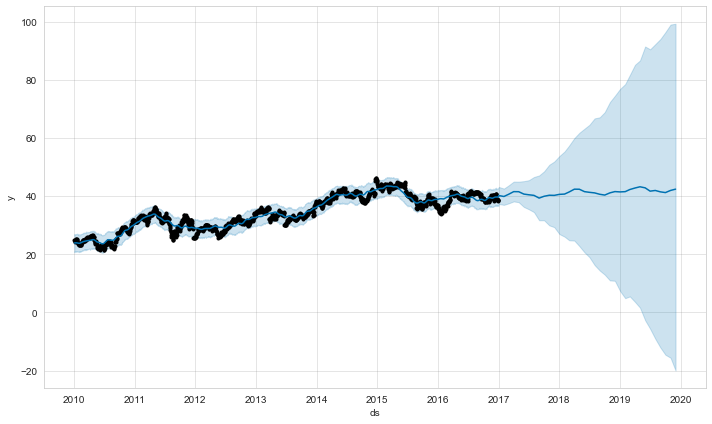

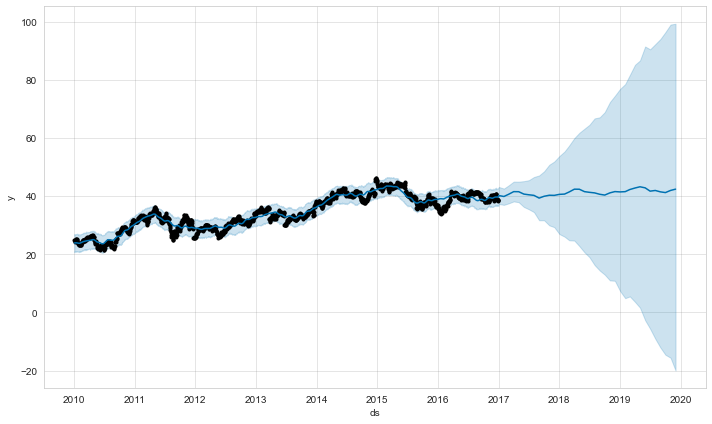

In [36]:
prophet.plot(forecast, uncertainty=True)

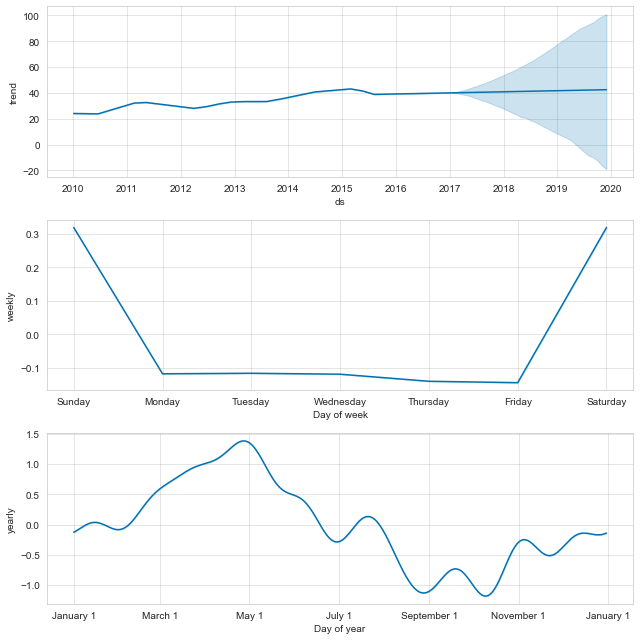

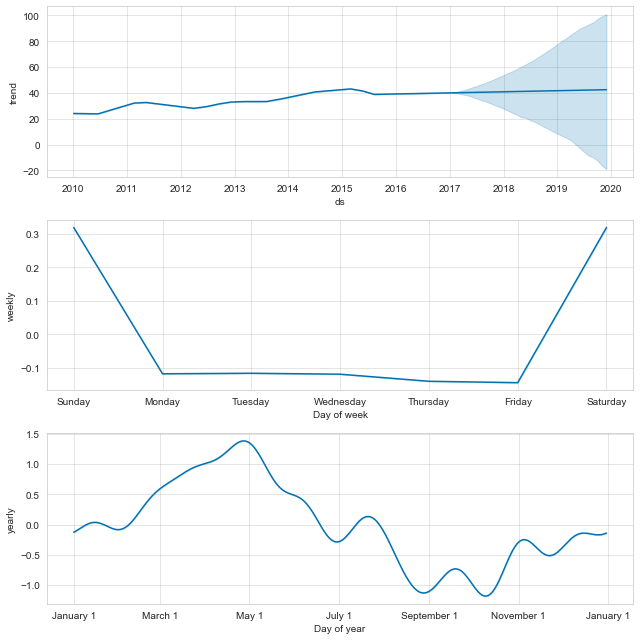

In [37]:
prophet.plot_components(forecast)

### Fitting FBProphet Model To ONEOKE Dataset

In [ ]:
prophet.fit(oke_p)

### Making Future ONEOKE Data For Forecasting

In [ ]:
future_oke_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_oke_dates.tail()

### FBProphet ONEOKE Price Forecasting

In [ ]:
forecast = prophet.predict(future_oke_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prophet.plot(forecast, uncertainty=True)

In [ ]:
prophet.plot_components(forecast)